In [2]:
import yaml

In [3]:
# load menu
with open("mnt/city-directories/01-user-input/menu.yml", 'r') as f:
    menu = yaml.safe_load(f)

In [9]:
if menu['IDP']:
    import os
    import glob
    import math
    import geopandas as gpd
    import pandas as pd
    import numpy as np
    from io import StringIO
    import requests
    from sklearn.preprocessing import MinMaxScaler
    from shapely.geometry import shape
    from shapely.ops import unary_union
    import pint
    import folium
    from pathlib import Path
    import matplotlib.pyplot as plt
    import requests
    import re
    import rasterio
    from rasterio.mask import mask
    from shapely.geometry import Point
    from fiona.crs import from_epsg
    from nbconvert import MarkdownExporter
    import nbformat
    import base64
    import pickle
    import plotly.graph_objects as go
    import seaborn as sns
    import plotly.express as px
    import csv

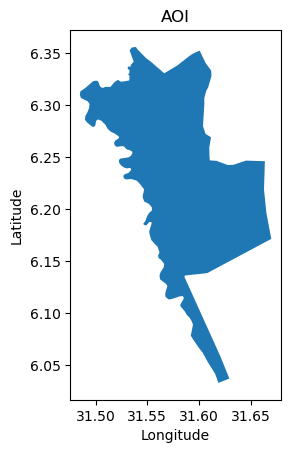

In [6]:
# SET UP ##############################################

# load city inputs files, to be updated for each city scan
with open("mnt/city-directories/01-user-input/city_inputs.yml", 'r') as f:
    city_inputs = yaml.safe_load(f)

city = city_inputs['city_name'].replace(' ', '_').lower()
country = city_inputs['country_name'].replace(' ', '_').lower()
# load global inputs, such as data sources that generally remain the same across scans
with open("global_inputs.yml", 'r') as f:
    global_inputs = yaml.safe_load(f)

# Read AOI shapefile --------
# transform the input shp to correct prj (epsg 4326)
aoi_file = gpd.read_file(city_inputs['AOI_path']).to_crs(epsg = 4326)
features = aoi_file.geometry

# Define output folder ---------
output_folder = Path('mnt/city-directories/02-process-output')
# Define render folder ---------
render_folder = Path('mnt/city-directories/03-render-output')
multi_scan_folder = Path('multi-scan-materials')

if not os.path.exists(output_folder):
    os.mkdir(output_folder)

fig, ax = plt.subplots()
features.plot(ax=ax)
plt.title('AOI')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [16]:
#import DTM layers

def import_idp_csv(idp_path):
    data = []
    with open(idp_path, 'r') as csvfile:
        csv_reader = csv.reader(csvfile)
        for row in csv_reader:
            data.append(row)
    return data

idp_site_path = 'mnt/city-directories/01-user-input/R11 Site Assessment.csv'
idp_site_assessment = import_idp_csv(idp_site_path)
idp_baseline_path =' '

[['\ufeffa02.mt.round', 'a04.enum.sex', 'b01.location.ssid', 'b02.location.name', 'b03.nearest.vn', 'b04.state.name', 'b05.state.pcode', 'b06.county.name', 'b07.county.pcode', 'b08.payam.name', 'b09.payam.pcode', 'b10.gps.lon', 'b11.gps.lat', 'b13.accessibility', 'b14.settlement.type', 'b17.idp.disp.reason', 'b18.idp.disp.reason.other.specify', 'b19.origin.largest.idp.grp.adm1', 'b20.origin.largest.idp.grp.adm2', 'b21.origin.largest.idp.grp.adm3', 'b21.01.origin.largest.idp.grp.payam.other', 'b23.origin.2nd.largest.idp.grp.adm1', 'b24.origin.2nd.largest.idp.grp.adm2', 'b25.origin.2nd.largest.idp.grp.adm3', 'b25.01.origin.2nd.largest.idp.grp.payam.other', 'b27.origin.3rd.largest.idp.grp.adm1', 'b28.origin.3rd.largest.idp.grp.adm2', 'b29.origin.3rd.largest.idp.grp.adm3', 'b29.01.origin.3rd.largest.idp.grp.payam.other', 'b34.site.ownership', 'b35.community.leader.onsite', 'b36.community.leader.whynot', 'b39.site.management.agency', 'b40.cccm.mobile.team', 'b44.reg.activity', 'b46.comm.dec